## HW3: Decision Tree, AdaBoost and Random Forest
In hw3, you need to implement decision tree, adaboost and random forest by using only numpy, then train your implemented model by the provided dataset and test the performance with testing data

Please note that only **NUMPY** can be used to implement your model, you will get no points by simply calling sklearn.tree.DecisionTreeClassifier

In [415]:
!pip install pycodestyle
!pip install --index-url https://test.pypi.org/simple/ nbpep8

Looking in indexes: https://test.pypi.org/simple/


## Load data
The dataset is the Heart Disease Data Set from UCI Machine Learning Repository. It is a binary classifiation dataset, the label is stored in `target` column. **Please note that there exist categorical features which need to be [one-hot encoding](https://www.datacamp.com/community/tutorials/categorical-data) before fit into your model!**
See follow links for more information
https://archive.ics.uci.edu/ml/datasets/heart+Disease

In [457]:
from sklearn.metrics import accuracy_score
from nbpep8.nbpep8 import pep8
from google.colab import drive
import pandas as pd
import numpy as np
drive.mount('/content/drive')

file_url = "http://storage.googleapis.com/download.tensorflow.org/data/heart.csv"
filepath = "/content/drive/MyDrive/四下/pattern_recognition/HW/HW3/npy/"

df = pd.read_csv(file_url)
pep8(_ih)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
cell_content.py:8:80: E501 line too long (81 > 79 characters)



In [458]:
# read train_df, test_df
train_idx = np.load(filepath + 'train_idx.npy')
test_idx = np.load(filepath + 'test_idx.npy')
train_df = df.iloc[train_idx]
test_df = df.iloc[test_idx]

# extract Y and Y_test
y = train_df.iloc[:, -1].to_numpy()
y_test = test_df.iloc[:, -1].to_numpy()
Y = y.reshape((y.shape[0], 1))
Y_test = y_test.reshape((y_test.shape[0], 1))

# one-hot encoding : X, X_test
train_df_onehot = train_df.loc[:, train_df.columns != 'target'].copy()
test_df_onehot = test_df.loc[:, test_df.columns != 'target'].copy()

discrete_f = ['cp', 'thal']
for f in discrete_f:
    train_df_onehot = pd.get_dummies(train_df_onehot, columns=[f], prefix=[f])
    test_df_onehot = pd.get_dummies(test_df_onehot, columns=[f], prefix=[f])

# Note : X_train contains a redundant column cp_0
del train_df_onehot['cp_0']

X = train_df_onehot.to_numpy()
X_test = test_df_onehot.to_numpy()

pep8(_ih)

In [459]:
train_df_onehot.head()

,age,sex,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,cp_1,cp_2,cp_3,cp_4,thal_fixed,thal_normal,thal_reversible
136,54,1,192,283,0,2,195,0,0.0,1,1,0,1,0,0,0,0,1
232,58,0,170,225,1,2,146,1,2.8,2,2,0,0,0,1,1,0,0
233,56,1,130,221,0,2,163,0,0.0,1,0,0,1,0,0,0,0,1
184,46,1,120,249,0,2,144,0,0.8,1,0,0,0,0,1,0,0,1
84,55,0,135,250,0,2,161,0,1.4,2,0,0,1,0,0,0,1,0


In [460]:
test_df_onehot.head()

,age,sex,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,cp_1,cp_2,cp_3,cp_4,thal_fixed,thal_normal,thal_reversible
21,58,0,150,283,1,2,162,0,1.0,1,0,1,0,0,0,0,1,0
25,50,0,120,219,0,0,158,0,1.6,2,0,0,0,1,0,0,1,0
7,57,0,120,354,0,0,163,1,0.6,1,0,0,0,0,1,0,1,0
92,64,1,125,309,0,0,131,1,1.8,2,0,0,0,1,0,0,0,1
89,59,1,140,221,0,0,164,1,0.0,1,0,0,1,0,0,0,1,0


## Question 1
Gini Index or Entropy is often used for measuring the “best” splitting of the data. Please compute the Entropy and Gini Index of provided data. Please use the formula from [page 5 of hw3 slides](https://docs.google.com/presentation/d/1kIe_-YZdemRMmr_3xDy-l0OS2EcLgDH7Uan14tlU5KE/edit#slide=id.gd542a5ff75_0_15)

In [461]:
def gini(sequence):
    g = 1.0
    n = sequence.size
    unique, cnts = np.unique(sequence, return_counts=True)
    g -= np.sum((cnts / n) ** 2)
    return g


def entropy(sequence):
    e = 0.0
    n = sequence.size
    unique, cnts = np.unique(sequence, return_counts=True)

    for cnt in cnts:
        p = (cnt / n)
        e -= p * np.log2(p)
    return e


# 1 = class 1,
# 2 = class 2
data = np.array([1, 2, 1, 1, 1, 1, 2, 2, 1, 1, 2])
print("Gini of data is ", gini(data))
print("Entropy of data is ", entropy(data))
pep8(_ih)

Gini of data is  0.4628099173553719
Entropy of data is  0.9456603046006401



## Question 2
Implement the Decision Tree algorithm (CART, Classification and Regression Trees) and trained the model by the given arguments, and print the accuracy score on the test data. You should implement two arguments for the Decision Tree algorithm
1. **criterion**: The function to measure the quality of a split. Your model should support `gini` for the Gini impurity and `entropy` for the information gain. 
2. **max_depth**: The maximum depth of the tree. If `max_depth=None`, then nodes are expanded until all leaves are pure. `max_depth=1` equals to split data once


In [462]:
# define the functions which will be used later
def my_accuracy_score(pred, test):
    pred = pred.flatten()
    test = test.flatten()
    cnt = 0.0
    for i in range(pred.shape[0]):
        if(pred[i] == test[i]):
            cnt += 1.0
    return cnt / pred.shape[0]


def gini_w(y, w=None):
    g = 1.0
    uniq_vals = np.unique(y)
    if(w is None):
        w = np.ones((len(y)))
    for val in uniq_vals:
        g -= (np.sum(w[y == val]) / np.sum(w)) ** 2
    return g


# w is not used
def entropy_w(y, w=None):
    e = 0.0
    n = y.size
    unique, cnts = np.unique(y, return_counts=True)
    for cnt in cnts:
        p = (cnt / n)
        e -= p * np.log2(p)
    return e


class Node():
    def __init__(self):
        # structure
        self.left = None
        self.right = None
        self.predict_class = None
        # infos
        self.feature = None
        self.thres = None
        self.impurity = None
        self.num_data = None

    def set_infos(self, feature, thres, impurity, num_data):
        self.feature = feature
        self.thres = thres
        self.impurity = impurity
        self.num_data = num_data


pep8(_ih)

In [463]:
feature_names = train_df_onehot.columns.values.tolist()
# --------------------------------------------------------------------------- #
# class DecisionTree()                                                        #
#     1. def train()                                                          #
#         - def build_tree()                                                  #
#             - cal_impurity                                                  #
#             - def best_split                                                #
#     2. def predict()                                                        #
#         - def traverse()                                                    #
#     3. def feature_importance()                                             #
#         - def get_fi()                                                      #
# --------------------------------------------------------------------------- #


class DecisionTree():
    def __init__(self, criterion='gini', max_depth=None):
        self.root = None
        self.err_func = gini_w if criterion == 'gini' else entropy_w
        self.max_depth = max_depth
        self.total_fi = None

    def train(self, X, Y, w=None):
        if(w is None):
            w = np.array([1 / len(y) * len(y)])
        data = np.hstack((X, Y))
        self.root = self.build_tree(data, w, self.max_depth)

    def cal_impurity(self, i, thres, data, w):
        feature_i = data[:, i]
        # 1. split left and right data
        left_data = data[feature_i < thres]
        right_data = data[feature_i >= thres]
        left_w = w[feature_i < thres]
        right_w = w[feature_i >= thres]

        # 2. calculate impurity
        left_impurity = self.err_func(left_data[:, -1], left_w)
        right_impurity = self.err_func(right_data[:, -1], right_w)

        # 2-1. sum up left and right impurity
        impurity = 0.0
        if(not np.isnan(left_impurity)):
            impurity = left_data.shape[0] * left_impurity
        if(not np.isnan(right_impurity)):
            impurity += right_data.shape[0] * right_impurity
        impurity /= data.shape[0]
        return impurity

    def best_split(self, data, w):
        thres = None
        feature = None
        min_impurity = 0.99
        n, feature_idx = data.shape

        # 1. loop through features
        #    feature_idx should minus 1 since the last feature is 'target'
        for i in range(feature_idx - 1):

            # 2. loop through all values to decide best threshold
            feature_i = data[:, i]
            data_sorted = np.sort(feature_i)

            # loop through values in this feature
            for j in range(1, n + 1):
                # 3. Use either discrete or continuous threshold
                thres1 = thres2 = (data_sorted[j - 1])
                if(j < n):
                    # skip duplicate value to improve efficiency
                    if data_sorted[j] == data_sorted[j - 1]:
                        continue
                    thres2 = (data_sorted[j - 1] + data_sorted[j]) + 0.0 / 2

                # 4. select the threshold with smaller impuruty
                impurity1 = self.cal_impurity(i, thres1, data, w)
                impurity2 = self.cal_impurity(i, thres2, data, w)
                if (impurity2 <= impurity1):
                    impurity1, thres1 = impurity2, thres2

                # 5. update infos if the split has smaller impurity
                if impurity1 <= min_impurity:
                    feature = i
                    thres = thres1
                    min_impurity = impurity1

        return feature, thres, min_impurity

    def build_tree(self, data, w, depth=None):
        # recursive termination condition
        if(data.size <= 1):
            return None

        # initilaization
        y = np.int_(data[:, -1])
        node = Node()

        # stopping rules
        if self.err_func(y, w) == 0 or (np.unique(y).size) == 1:
            node.predict_class = int(data[0, -1])
        elif depth == 0:
            label, cnt = np.unique(y, return_counts=True)
            node.predict_class = label[np.argmax(cnt)]
        # recursively build trees
        else:
            # 1. get the best split
            feature_idx, thres, impurity = self.best_split(data, w)
            node.set_infos(feature_idx, thres, impurity, data.size)

            # 2. split data
            feature = data[:, feature_idx]
            left_idx = feature < thres
            right_idx = feature >= thres
            left_data = data[left_idx]
            right_data = data[right_idx]

            # 2-1. When entering this section, stop splitting to
            #      avoid finding an unique path to data
            if (left_data.size == 0) or (right_data.size == 0):
                node.predict_class = int(data[0, -1])
                return node

            # 3. recursively grow left and right nodes
            depth_ = depth if depth is None else (depth - 1)
            tmp_left = self.build_tree(left_data, w[left_idx], depth_)
            tmp_right = self.build_tree(right_data, w[right_idx], depth_)

            # 3-1. set left & right nodes only if nodes != null
            if(tmp_left is not None and tmp_right is not None):
                node.left = tmp_left
                node.right = tmp_right
        return node

    def traverse(self, node, X):
        if node.predict_class is not None:
            return node.predict_class
        else:
            if X[node.feature] < node.thres:
                return self.traverse(node.left, X)
            else:
                return self.traverse(node.right, X)

    def predict(self, X, Y=None):
        pred = np.zeros(X.shape[0]).astype(int)
        correct = 0
        for i in range(X.shape[0]):
            pred[i] = self.traverse(self.root, X[i])
            if pred[i] == Y[i, 0]:
                correct += 1
        acc = correct / X.shape[0] if Y is not None else None
        # print(f'acc = {acc}')
        return pred, acc

    def get_fi(self, node):
        if node.left and node.left.impurity is not None:
            self.get_fi(node.left)
        if node.right and node.right.impurity is not None:
            self.get_fi(node.right)
        self.total_fi[node.feature] += 1

    def feature_importance(self):
        self.total_fi = np.zeros(len(feature_names))
        self.get_fi(self.root)
        return self.total_fi


pep8(_ih)

### Question 2.1
Using `criterion=gini`, showing the accuracy score of test data by `max_depth=3` and `max_depth=10`, respectively.


In [464]:
# --------------------------------------------------------------------------- #
# 1. clf_depth3                                                               #
#    : DecisionTree(criterion='gini', max_depth=3)                            #
# --------------------------------------------------------------------------- #
clf_depth3 = DecisionTree(criterion='gini', max_depth=3)
w = np.array([1 / len(X)] * len(X))
clf_depth3.train(X, Y, w)
Y_pred, acc = clf_depth3.predict(X_test, Y_test)
print("Acc of clf_depth3")
print("acc = ", acc)
print()


# --------------------------------------------------------------------------- #
# 2. clf_depth10                                                              #
#    : DecisionTree(criterion='gini', max_depth=10)                           #
# --------------------------------------------------------------------------- #
clf_depth10 = clf_depth3 = DecisionTree(criterion='gini', max_depth=10)
clf_depth10.train(X, Y, w)
Y_pred, acc = clf_depth10.predict(X_test, Y_test)
print("Acc of clf_depth10")
print("acc = ", acc)
pep8(_ih)

Acc of clf_depth3
acc =  0.78

Acc of clf_depth10
acc =  0.75



### Question 2.2
Using `max_depth=3`, showing the accuracy score of test data by `criterion=gini` and `criterion=entropy`, respectively.


In [465]:
# --------------------------------------------------------------------------- #
# 1. clf_gini                                                                 #
#    : DecisionTree(criterion='gini', max_depth=3)                            #
# --------------------------------------------------------------------------- #
clf_gini = DecisionTree(criterion='gini', max_depth=3)
w = np.array([1 / len(X)] * len(X))
clf_gini.train(X, Y, w)
Y_pred, acc = clf_gini.predict(X_test, Y_test)
print("Acc of clf_gini")
print("acc = ", acc)
print()

# --------------------------------------------------------------------------- #
# 2. clf_entropy                                                              #
#    : DecisionTree(criterion='entropy', max_depth=3)                         #
# --------------------------------------------------------------------------- #
clf_entropy = DecisionTree(criterion='entropy', max_depth=3)
clf_entropy.train(X, Y, w)
Y_pred, acc = clf_entropy.predict(X_test, Y_test)
print("Acc of clf_entropy")
print("acc = ", acc)
pep8(_ih)

Acc of clf_gini
acc =  0.78

Acc of clf_entropy
acc =  0.75



### Additional test 2.3

In [404]:
# --------------------------------------------------------------------------- #
max = 0.0
max_i = 0
for i in range(1, 10):
  clf_depth15 = DecisionTree(criterion='gini', max_depth=i)
  clf_depth15.train(X, Y, w)
  Y_pred, acc = clf_depth15.predict(X_test, Y_test)
  #print("Acc of clf_depth10")
  #print("acc = ", acc)
  if(acc >= max):
    max = acc
    max_i = i
print(max)
print(max_i)

0.8
5


- Note: Your decisition tree scores should over **0.7**. It may suffer from overfitting, if so, you can tune the hyperparameter such as `max_depth`
- Note: You should get the same results when re-building the model with the same arguments,  no need to prune the trees
- Hint: You can use the recursive method to build the nodes


## Question 3
Plot the [feature importance](https://sefiks.com/2020/04/06/feature-importance-in-decision-trees/) of your Decision Tree model. You can get the feature importance by counting the feature used for splitting data.

- You can simply plot the **counts of feature used** for building tree without normalize the importance. Take the figure below as example, outlook feature has been used for splitting for almost 50 times. Therefore, it has the largest importance

![image](https://i2.wp.com/sefiks.com/wp-content/uploads/2020/04/c45-fi-results.jpg?w=481&ssl=1)

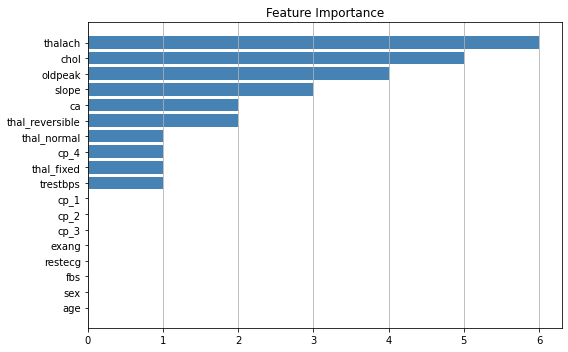

In [466]:
import matplotlib.pyplot as plt
fi = clf_depth10.feature_importance()

fi_df = pd.DataFrame({'f_names': feature_names, 'f_importance': fi})
fi_df.sort_values(by=['f_importance'], inplace=True)
f_idx = np.arange(len(feature_names))

plt.figure(figsize=(8, 5))
plt.barh(f_idx, fi_df['f_importance'], color='steelblue')
plt.xticks(np.arange(np.max(fi) + 1))
plt.yticks(f_idx, fi_df['f_names'])

plt.gca().grid(axis='x', which='major')
plt.title('Feature Importance')
plt.tight_layout()
plt.show()
pep8(_ih)

## Question 4
implement the AdaBooest algorithm by using the CART you just implemented from question 2 as base learner. You should implement one arguments for the AdaBooest.
1. **n_estimators**: The maximum number of estimators at which boosting is terminated

In [467]:
# --------------------------------------------------------------------------- #
# class Adaboost()                                                            #
#     def train()                                                             #
#     def predict()                                                           #
# --------------------------------------------------------------------------- #


class Adaboost():
    def __init__(self, n_estimators, criterion='gini', max_depth=1):
        self.n_estimators = n_estimators
        self.criterion = 'gini'
        self.max_depth = 1
        self.w = None
        self.alphas = []
        self.stumps = []
        self.weakLearner = DecisionTree

    def train(self, X, Y):
        self.w = np.array([1 / len(X)] * len(X))
        M = self.n_estimators
        prev_acc = 0
        prev_w = self.w

        for m in range(M):
            # 1. train a new stump
            G_m = self.weakLearner(criterion=self.criterion,
                                   max_depth=self.max_depth)
            G_m.train(X, Y, self.w)
            predictions, acc = G_m.predict(X, Y)

            # reset w and train again to avoid convergence on w
            if acc == prev_acc:
                self.w = np.array([1 / len(X)] * len(X))
                G_m.train(X, Y, self.w)
                predictions, acc = G_m.predict(X, Y)
            prev_acc = acc

            # 2. ε : error
            error = 0.0
            for i, pred in enumerate(predictions):
                if(Y[i] != pred):
                    error += 1 * self.w[i]
            error /= np.sum(w)

            # 3. α = 1/2・ln[(1-ε)/ε]
            EPS = 1e-6
            alpha = 0.5 * np.log((1 - error + EPS) / (error + EPS))

            # 4.update weights
            #   w *= e^α if predicted wrong
            #   w *= e^-α if predicted correctly
            for i, pred in enumerate(predictions):
                if(Y[i] != pred):
                    self.w[i] *= np.exp(alpha)
                else:
                    self.w[i] *= np.exp(-alpha)
            self.w /= np.sum(self.w)

            # 5. record the stump
            self.stumps.append(G_m)
            self.alphas.append(alpha)

    def predict(self, X_test, Y_test):
        M = self.n_estimators
        sum_y_pred = np.zeros(len(Y_test))
        for m in range(M):
            # get pred from stump_m
            pred, _ = self.stumps[m].predict(X_test, Y_test)

            # map label 0 to -1
            pred[pred == 0] = -1.0

            # sign(∑αh(x))
            sum_y_pred = np.add(sum_y_pred, self.alphas[m] * pred)
            y_pred = np.sign(sum_y_pred)

            # map label -1 back to 0
            y_pred[y_pred == -1] = 0
        return y_pred, my_accuracy_score(Y_test, Y_pred)


pep8(_ih)

### Question 4.1
Show the accuracy score of test data by `n_estimators=10` and `n_estimators=100`, respectively.


In [429]:
# --------------------------------------------------------------------------- #
# 1. Adaboost(n_estimators=10)                                                #
# --------------------------------------------------------------------------- #
tree_clf = Adaboost(n_estimators=10)
tree_clf.train(X, Y)
Y_pred, acc = tree_clf.predict(X_test, Y_test)
print("Acc of Adaboost(n_estimators=10) : {}".format(acc))
print()

# --------------------------------------------------------------------------- #
# 2. Adaboost(n_estimators=100)                                               #
# --------------------------------------------------------------------------- #
tree_clf = Adaboost(n_estimators=100)
tree_clf.train(X, Y)
Y_pred, acc = tree_clf.predict(X_test, Y_test)
print("Acc of Adaboost(n_estimators=100) : {}".format(acc))
pep8(_ih)

Acc of Adaboost(n_estimators=10) : 0.75

Acc of Adaboost(n_estimators=100) : 0.83



## Question 5
implement the Random Forest algorithm by using the CART you just implemented from question 2. You should implement three arguments for the Random Forest.

1. **n_estimators**: The number of trees in the forest. 
2. **max_features**: The number of random select features to consider when looking for the best split
3. **bootstrap**: Whether bootstrap samples are used when building tree


### RandomTree

In [468]:
import random
# --------------------------------------------------------------------------- #
# class RandomForest()                                                        #
#     def train()                                                             #
#     def predict()                                                           #
# --------------------------------------------------------------------------- #


class RandomForest():
    def __init__(self, n_estimators, max_features, boostrap=True,
                 criterion='gini', max_depth=None):
        self.n_estimators = n_estimators
        self.max_features = int(np.round(max_features))
        self.boostrap = boostrap
        self.criterion = criterion
        self.max_depth = max_depth
        self.clfs = []
        self.random_fs = []

    def train(self, X, Y, k):
        w = np.array([1 / len(X)] * len(X))
        cnt_X, cnt_features = X.shape
        for i in range(self.n_estimators):
            # 1. randomly picked features
            random.seed(2 * i + 1)
            random_f = random.sample(range(cnt_features), self.max_features)

            # 1-1. store the selected feature (by indexes)
            self.random_fs.append(random_f)

            # 2. Initialize a classifier
            self.clfs.append(DecisionTree(self.criterion, self.max_depth))

            # 3.  boostrap
            if self.boostrap:
                # 3-1. randomly pick 2/3 data from X (can select same data)
                random.seed(i + k)
                cnt_sample = int(np.round(cnt_X * 3 / 4))
                subset_idx = random.sample(range(cnt_X), cnt_sample)
                # 3-2. train on the subset data
                self.clfs[i].train(X[subset_idx][:, random_f],
                                   Y[subset_idx], w[subset_idx])
            else:
                self.clfs[i].train(X[:, random_f], Y, w)

    def predict(self, X, Y=None):
        correct = 0.0
        cnt_X = X.shape[0]
        pred = np.zeros(cnt_X, dtype=int)

        # loop through all test data
        for i in range(cnt_X):
            vote = []
            # loop through all ensimators
            for j in range(self.n_estimators):
                # xj : Use the same feature columns with the random_vector[j]
                xj = X[i, self.random_fs[j]]
                # predict and vote
                pred_j = self.clfs[j].traverse(self.clfs[j].root, xj)
                vote.append(pred_j)

            # majority vote
            label, cnt = np.unique(vote, return_counts=True)
            pred[i] = label[np.argmax(cnt)]
        # accuracy
        acc = my_accuracy_score(pred, Y)
        print("acc = ", acc)
        return pred, acc


pep8(_ih)

### Question 5.1
Using `criterion=gini`, `max_depth=None`, `max_features=sqrt(n_features)`, showing the accuracy score of test data by `n_estimators=10` and `n_estimators=100`, respectively.


In [469]:
# --------------------------------------------------------------------------- #
# 1. clf_10tree                                                               #
#    : RandomForest(n_estimators=10, max_features=np.sqrt(x_train.shape[1]))  #
# --------------------------------------------------------------------------- #
clf_10tree = RandomForest(n_estimators=10,
                          max_features=np.sqrt(X.shape[1]))
clf_10tree.train(X, Y, 11)
pred, acc = clf_10tree.predict(X_test, Y_test)
print("Acc of clf_10tree : {}".format(acc))
print()

# --------------------------------------------------------------------------- #
# 2. clf_100tree                                                              #
#    : RandomForest(n_estimators=100, max_features=np.sqrt(x_train.shape[1])) #
# --------------------------------------------------------------------------- #
clf_100tree = RandomForest(n_estimators=100,
                           max_features=np.sqrt(X.shape[1]))
clf_100tree.train(X, Y, 17)
pred, acc = clf_100tree.predict(X_test, Y_test)
print("Acc of clf_100tree : {}".format(acc))
pep8(_ih)

acc =  0.85
Acc of clf_10tree : 0.85

acc =  0.83
Acc of clf_100tree : 0.83



### Question 5.2
Using `criterion=gini`, `max_depth=None`, `n_estimators=10`, showing the accuracy score of test data by `max_features=sqrt(n_features)` and `max_features=n_features`, respectively.


- Note: Use majority votes to get the final prediction, you may get slightly different results when re-building the random forest model

In [470]:
# --------------------------------------------------------------------------- #
# 1. clf_random_features                                                      #
#    : RandomForest(n_estimators=10, max_features=np.sqrt(x_train.shape[1]))  #
# --------------------------------------------------------------------------- #
clf_random_features = RandomForest(n_estimators=10,
                                   max_features=np.sqrt(X.shape[1]))
clf_random_features.train(X, Y, 11)
_, acc = clf_random_features.predict(X_test, Y_test)
print("Acc of clf_random_features : {}".format(acc))
print()

# --------------------------------------------------------------------------- #
# 2. clf_all_features                                                         #
#    : RandomForest(n_estimators=10, max_features=n_features)                 #
# --------------------------------------------------------------------------- #
clf_all_features = RandomForest(n_estimators=10, max_features=X.shape[1])
clf_all_features.train(X, Y, 29)
_, acc = clf_all_features.predict(X_test, Y_test)
print("Acc of clf_all_features : {}".format(acc))
pep8(_ih)

acc =  0.85
Acc of clf_random_features : 0.85

acc =  0.82
Acc of clf_all_features : 0.82



## Question 6.
Try you best to get highest test accuracy score by 
- Feature engineering
- Hyperparameter tuning
- Implement any other ensemble methods, such as gradient boosting. Please note that you cannot call any package. Also, only ensemble method can be used. Neural network method is not allowed to used.

In [471]:
# one-hot encoding : X, X_test
train_df_onehot = train_df.loc[:, train_df.columns != 'target'].copy()
test_df_onehot = test_df.loc[:, test_df.columns != 'target'].copy()

discrete_f = ['restecg', 'slope', 'ca', 'cp', 'thal']
for f in discrete_f:
    train_df_onehot = pd.get_dummies(train_df_onehot, columns=[f], prefix=[f])
    test_df_onehot = pd.get_dummies(test_df_onehot, columns=[f], prefix=[f])

# Note : X_train contains a redundant column cp_0
del train_df_onehot['cp_0']

X = train_df_onehot.to_numpy()
X_test = test_df_onehot.to_numpy()
feature_names = train_df_onehot.columns.values.tolist()

pep8(_ih)

In [473]:
class RandomForest_with_filter(RandomForest):

    def train(self, X, Y, k):
        # self.boostrap = False
        w = np.array([1 / len(X)] * len(X))
        cnt_X, cnt_features = X.shape
        for i in range(self.n_estimators):
            acc_i = 0.0
            ranseed = 0
            while(acc_i < 0.6):
                # 1. randomly picked features
                ranseed += 1
                random.seed(i + ranseed)
                random_fi = random.sample(range(cnt_features),
                                          self.max_features)
                # 2. Initialize a classifier
                clf_i = DecisionTree(self.criterion, self.max_depth)

                # 3.  boostrap
                if self.boostrap:
                    # 3-1. randomly pick 2/3 data from X (same data is allowed)
                    ranseed += k
                    random.seed(i + ranseed)
                    cnt_sample = int(np.round(cnt_X * 2 / 3))
                    subset_idx = random.sample(range(cnt_X), cnt_sample)
                    # 3-2. train on the subset data
                    clf_i.train(X[subset_idx][:, random_fi],
                                Y[subset_idx], w[subset_idx])
                else:
                    clf_i.train(X[:, random_fi], Y, w)
                pred_i, acc_i = clf_i.predict(X, Y)

            # store the indexes of selected feature
            self.random_fs.append(random_fi)

            # store the classifier
            self.clfs.append(clf_i)


pep8(_ih)

### Best record : 88%
* n_estimators=10,
* max_features=5, 
* max_depth=3
* random.seed(16)

In [474]:
# --------------------------------------------------------------------------- #
# 1. clf_10tree = RandomForest(n_estimators=10,                               #
#                              max_features=5,                                #
#                              max_depth=3).                                  #
# --------------------------------------------------------------------------- #
random_seed = 16
clf_10tree = RandomForest_with_filter(n_estimators=10,
                                      max_features=5,
                                      max_depth=3)
clf_10tree.train(X, Y, random_seed)
pred, acc = clf_10tree.predict(X_test, Y_test)
print("Acc of clf_10tree : {}".format(acc))
pep8(_ih)

acc =  0.88
Acc of clf_10tree : 0.88



### Best record : 87%
* n_estimators=25,
* max_features=5, 
* max_depth=3
* random.seed(9)

In [475]:
# --------------------------------------------------------------------------- #
# 1. clf_10tree = RandomForest(n_estimators=25,                               #
#                              max_features=5,                                #
#                              max_depth=3).                                  #
# --------------------------------------------------------------------------- #
random_seed = 9
clf_25tree = RandomForest_with_filter(n_estimators=25,
                                      max_features=5,
                                      max_depth=3)
clf_25tree.train(X, Y, random_seed)
pred, acc = clf_25tree.predict(X_test, Y_test)
print("Acc of clf_25tree : {}".format(acc))
pep8(_ih)

acc =  0.87
Acc of clf_25tree : 0.87



### accident: 89%
* RandomForest_with_filter
* n_estimators=*10*,
* max_features=5, 
* max_depth=3
* random.seed(None)



In [80]:
# --------------------------------------------------------------------------- #
# 1. clf_10tree = RandomForest_with_filter(n_estimators=10,                   #
#                                           max_features=5,                   #
#                                           max_depth=2).                     #
# --------------------------------------------------------------------------- #
acc = 0.0
iter = 0
while (acc < 0.86):
    clf_10tree = RandomForest_with_filter(n_estimators=10,
                              max_features=5, max_depth=2)
    clf_10tree.train(X, Y)
    pred, acc = clf_10tree.predict(X_test, Y_test)
    iter += 1
print("Final acc of clf_10tree : {}, iter = {}".format(acc, iter))
print()


# --------------------------------------------------------------------------- #
# 2. clf_10tree = RandomForest(n_estimators=10,                               #
#                              max_features=5,                                #
#                              max_depth=3).                                  #
# --------------------------------------------------------------------------- #
acc = 0.0
iter = 0
while (acc < 0.86):
    clf_10tree = RandomForest(n_estimators=10,
                              max_features=5, max_depth=3)
    clf_10tree.train(X, Y)
    pred, acc = clf_10tree.predict(X_test, Y_test)
    iter += 1
print("Final acc of clf_10tree : {}, iter = {}".format(acc, iter))
print()

acc =  0.8
acc =  0.85
acc =  0.8
acc =  0.82
acc =  0.81
acc =  0.83
acc =  0.81
acc =  0.81
acc =  0.84
acc =  0.82
acc =  0.81
acc =  0.86
Final acc of clf_10tree : 0.86, iter = 12

acc =  0.8
acc =  0.82
acc =  0.83
acc =  0.82
acc =  0.81
acc =  0.84
acc =  0.81
acc =  0.8
acc =  0.82
acc =  0.82
acc =  0.84
acc =  0.81
acc =  0.82
acc =  0.81
acc =  0.84
acc =  0.82
acc =  0.89
Final acc of clf_10tree : 0.89, iter = 17



#### testing block

In [128]:
acc = 0.0
iter = 0
while (acc < 0.87):
    clf_25tree = RandomForest_with_filter(n_estimators=25,
                              max_features=5, max_depth=2)
    clf_25tree.train(X, Y)
    pred, acc = clf_25tree.predict(X_test, Y_test)
    iter += 1
print("Final acc of clf_10tree : {}, iter = {}".format(acc, iter))
print()

acc =  0.88
Final acc of clf_10tree : 0.88, iter = 1



### Best record : 87%
* n_estimators=10,
* max_features=5, 
* max_depth=3
* random.seed(None)


In [49]:
acc = 0.0
iter = 0
while (acc < 0.87):
    clf_10tree = RandomForest(n_estimators=10,
                              max_features=5, max_depth=3)
    clf_10tree.train(X, Y)
    pred, acc = clf_10tree.predict(X_test, Y_test)
    iter += 1
print("Final acc of clf_10tree : {}, iter = {}".format(acc, iter))
print()

acc =  0.83
acc =  0.86
acc =  0.82
acc =  0.83
acc =  0.83
acc =  0.87
Final acc of clf_10tree : 0.87, iter = 6

